In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
from utils import *

#### GLU gf test

In [2]:
paths = [['/Users/theoares/Dropbox (MIT)/research/0nubb/tests/gf_test/hdf5/mom_3_32I_ml0p00' + str(n) + '.h5'] \
         for n in [4, 6, 8]]
n_ens = len(paths)
k1, k2 = np.array([-3, 0, 3, 0]), np.array([0, 3, 3, 0])
q = np.array([3, 3, 0, 0])
# (ens_idx, pad_idx, a, α, b, β)
props_k1 = np.zeros((n_ens, 1, 3, 4, 3, 4), dtype = np.complex64)
props_k2 = np.zeros((n_ens, 1, 3, 4, 3, 4), dtype = np.complex64)
props_q = np.zeros((n_ens, 1, 3, 4, 3, 4), dtype = np.complex64)
# (ens_idx, μ, a, α, b, β)
GV, GA = np.zeros((n_ens, 4, 1, 3, 4, 3, 4), dtype = np.complex64), np.zeros((n_ens, 4, 1, 3, 4, 3, 4), dtype = np.complex64)
# (ens_idx, n, a, α, b, β, c, γ, d, δ)
GO = np.zeros((n_ens, 16, 1, 3, 4, 3, 4, 3, 4, 3, 4), dtype = np.complex64)
for ii in range(n_ens):
    _, _, props_k1[ii], props_k2[ii], props_q[ii], GV[ii], GA[ii], GO[ii] = readfiles(paths[ii], q, True, chroma = True)

In [5]:
nb = 1
L = Lattice(32, 64)
scheme = 'gamma'                # scheme == 'gamma' or 'qslash'
F = getF(L, scheme)                # tree level projections
P = projectors(scheme, L.to_linear_momentum(q), L.to_linear_momentum(k1), L.to_linear_momentum(k2))

q = np.array([-3, -3, 0, 0])    # q = -q for chroma
q_lat = np.sin(L.to_linear_momentum(q))
Zq = np.zeros((n_ens, nb), dtype = np.complex64)
ZV, ZA = np.zeros((n_ens, nb), dtype = np.complex64), np.zeros((n_ens, nb), dtype = np.complex64)
Z = np.zeros((n_ens, 5, 5, nb), dtype = np.complex64)
Lambda_list = np.zeros((n_ens, 5, 5, nb), dtype = np.complex64)
for ii in range(n_ens):
    print('Ensemble idx: ' + str(ii))
    props_k1_b, props_k2_b, props_q_b = bootstrap(props_k1[ii]), bootstrap(props_k2[ii]), bootstrap(props_q[ii])
    GV_boot, GA_boot, GO_boot = np.array([bootstrap(GV[ii, mu]) for mu in range(4)]), np.array([bootstrap(GA[ii, mu]) for mu in range(4)]), np.array([bootstrap(GO[ii, n], Nb = nb) for n in range(16)])
    props_k1_inv, props_k2_inv, props_q_inv = invert_props(props_k1_b), invert_props(props_k2_b), invert_props(props_q_b)
    Zq[ii] = quark_renorm(props_q_inv, q_lat)
    GammaV, GammaA = np.zeros(GV_boot.shape, dtype = np.complex64), np.zeros(GA_boot.shape, dtype = np.complex64)
    qDotV, qDotA = np.zeros(GV_boot.shape[1:]), np.zeros(GA_boot.shape[1:])
    qlat_slash = slash(q_lat)
    print('Computing axial and vector renormalizations.')
    for mu in range(4):
        # GammaV[mu], GammaA[mu] = amputate_threepoint(props_k1_inv, props_k2_inv, GV_boot[mu]), amputate_threepoint(props_k1_inv, props_k2_inv, GA_boot[mu])
        GammaV[mu], GammaA[mu] = amputate_threepoint(props_k2_inv, props_k1_inv, GV_boot[mu]), amputate_threepoint(props_k2_inv, props_k1_inv, GA_boot[mu])
        qDotV, qDotA = qDotV + q_lat[mu] * GammaV[mu], qDotA + q_lat[mu] * GammaA[mu]
    ZV[ii] = 12 * Zq[ii] * square(q_lat) / np.einsum('zaiaj,ji->z', qDotV, qlat_slash)
    ZA[ii] = 12 * Zq[ii] * square(q_lat) / np.einsum('zaiaj,jk,ki->z', qDotA, gamma5, qlat_slash)

    print('Zq ~ ' + str(Zq[ii]))
    print('ZV ~ ' + str(ZV[ii]))
    print('ZA ~ ' + str(ZA[ii]))
    
    GammaO = np.zeros(GO_boot.shape, dtype = np.complex64)
    for n in range(16):
        print('Amputating Green\'s function for n = ' + str(n) + '.')
        GammaO[n] = amputate_fourpoint(props_k2_inv, props_k1_inv, GO_boot[n])
    SS = GammaO[0]
    PP = GammaO[15]
    VV = GammaO[1] + GammaO[2] + GammaO[4] + GammaO[8]
    # AA = GammaO[14] - GammaO[13] + GammaO[11] - GammaO[7]
    # TT = GammaO[3] + GammaO[5] + GammaO[9] + GammaO[6] + GammaO[10] + GammaO[12]
    AA = GammaO[14] + GammaO[13] + GammaO[11] + GammaO[7]
    TT = GammaO[3] + GammaO[5] + GammaO[9] + GammaO[6] + GammaO[10] + GammaO[12]

    # Get positive parity operator projections
    print('Projecting onto tree level vertex.')
    Gamma = [VV + AA, VV - AA, SS - PP, SS + PP, TT]
    Lambda = np.einsum('nbjaidlck,mzaibjckdl->zmn', P, Gamma)    # Lambda is n_boot x 5 x 5
    print('Lambda ~ ' + str(Lambda[0, :, :]))       # projected 4 pt function
    Lambda_list[ii, :, :, 0] = Lambda[0]         # save Lambda for chiral extrapolation
    Lambda_inv = np.linalg.inv(Lambda[0, :, :])
    Z[ii, :, :, 0] = (Zq[ii, 0] ** 2) * np.einsum('ik,kj->ij', F, Lambda_inv)

    print('Z_ij ~ ' + str(Z[ii, :, :, 0]))

Ensemble idx: 0
Computing axial and vector renormalizations.
Zq ~ [0.8703799+0.j]
ZV ~ [0.7814064-0.0001614j]
ZA ~ [0.7816593-0.00017276j]
Amputating Green's function for n = 0.
Amputating Green's function for n = 1.
Amputating Green's function for n = 2.
Amputating Green's function for n = 3.
Amputating Green's function for n = 4.
Amputating Green's function for n = 5.
Amputating Green's function for n = 6.
Amputating Green's function for n = 7.
Amputating Green's function for n = 8.
Amputating Green's function for n = 9.
Amputating Green's function for n = 10.
Amputating Green's function for n = 11.
Amputating Green's function for n = 12.
Amputating Green's function for n = 13.
Amputating Green's function for n = 14.
Amputating Green's function for n = 15.
Projecting onto tree level vertex.
Lambda ~ [[ 3.4352290e+03-1.2593246e+00j  2.3716917e+00-1.1834071e+00j
  -2.5922346e-01+1.5057954e-01j -2.0528308e-01-1.1964105e-03j
  -1.4894387e-01-3.9420360e-01j]
 [ 3.4253559e+00-2.3725228e+00

<IPython.core.display.Javascript object>


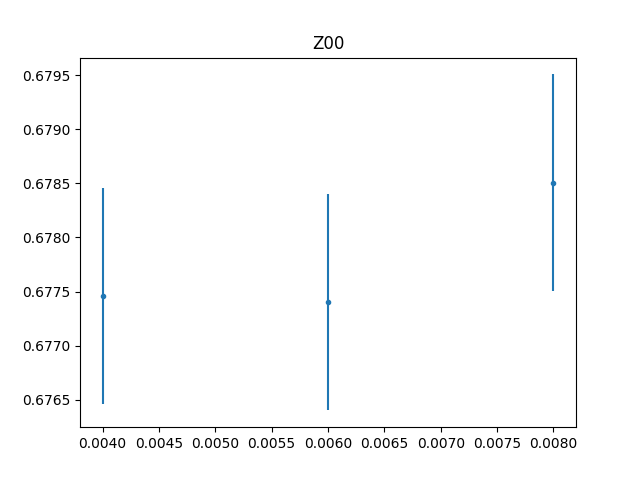

<IPython.core.display.Javascript object>


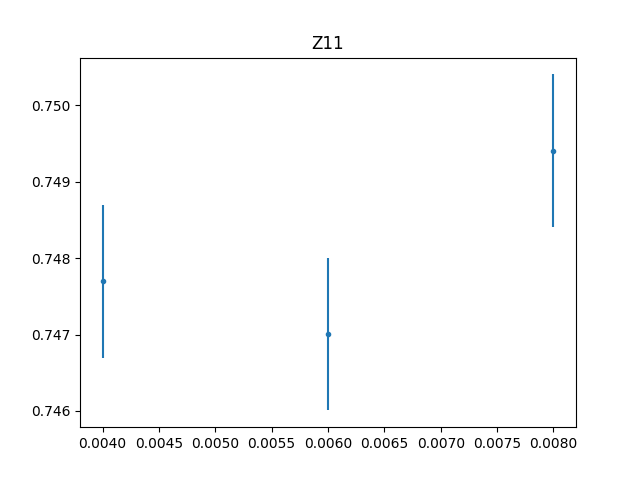

<IPython.core.display.Javascript object>


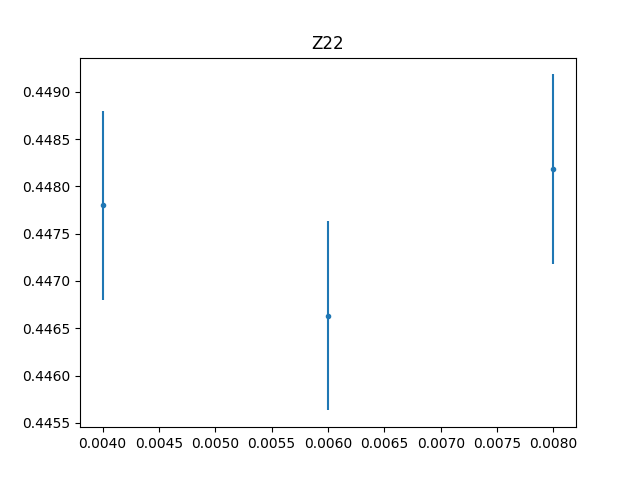

<IPython.core.display.Javascript object>


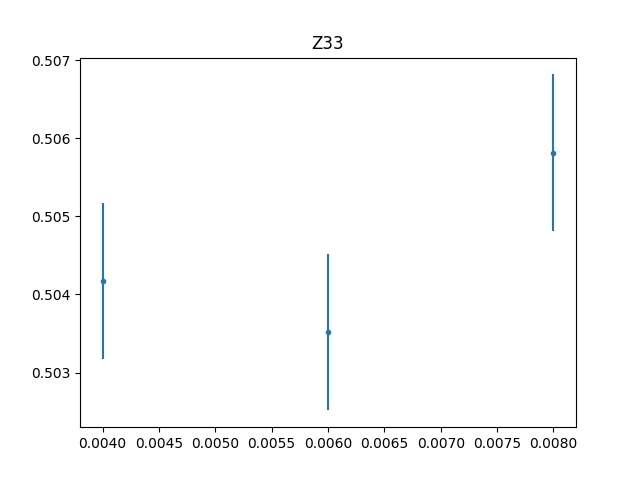

<IPython.core.display.Javascript object>


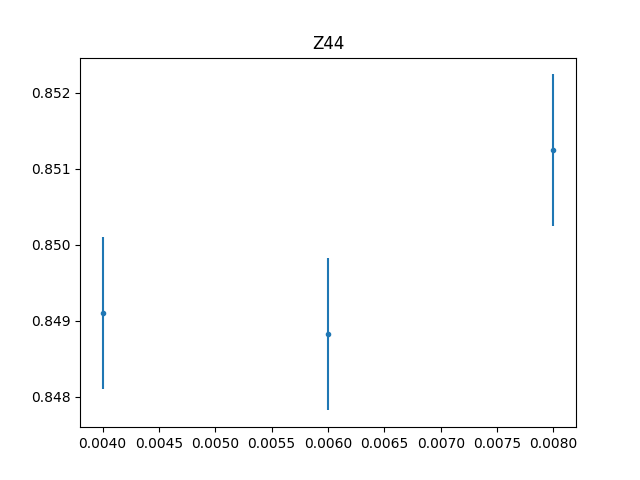

<IPython.core.display.Javascript object>


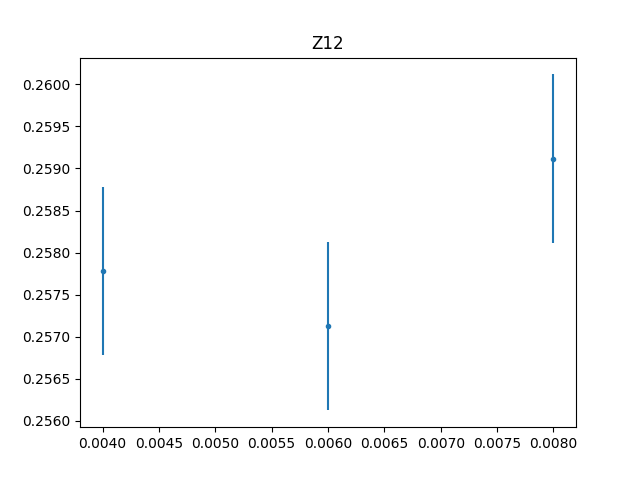

<IPython.core.display.Javascript object>


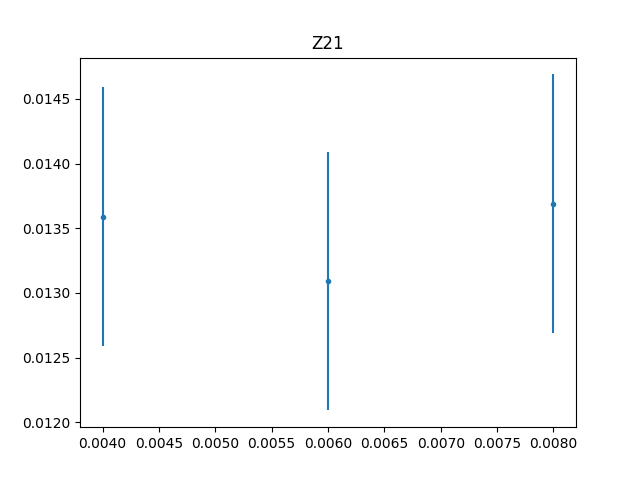

<IPython.core.display.Javascript object>


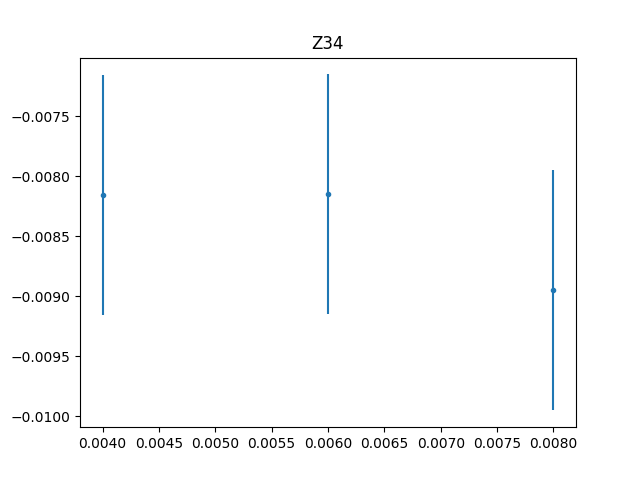

<IPython.core.display.Javascript object>


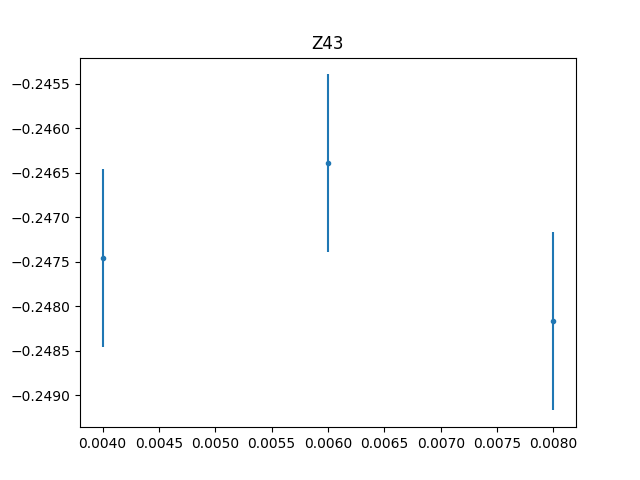

In [16]:
xx = np.array([0.004, 0.006, 0.008])
approx_yerr = np.array([1e-3 for n in range(n_ens)])
multiplets = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [1, 2], [2, 1], [3, 4], [4, 3]], dtype = object)
for ii, mult_idx in enumerate(multiplets):
    plt.figure()
    plt.errorbar(xx, np.real(Z[:, mult_idx[0], mult_idx[1], 0]), yerr = approx_yerr, fmt = '.')
    plt.title('Z' + str(mult_idx[0]) + str(mult_idx[1]))
    plt.show()

In [13]:
np.real(Z[:, 0, 0, 0])

array([0.6774597 , 0.6774018 , 0.67850626], dtype=float32)

#### Coulomb $\rightarrow$ Landau gf test

In [ ]:
# check if coulomb gf --> landau gf works
landau_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/tests/coulomb_landau_test/hdf5/landau.h5'
coul_landau_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/tests/coulomb_landau_test/hdf5/coul_landau.h5'
Fl = h5py.File(landau_file, 'r')
Fcl = h5py.File(coul_landau_file, 'r')

In [ ]:
landau_propq = Fl['prop_q/q3300'][()]
coul_landau_propq = Fcl['prop_q/q3300'][()]

In [ ]:
np.max(np.abs(landau_propq - coul_landau_propq))

In [ ]:
np.where(landau_propq == np.max(landau_propq))

In [ ]:
landau_propq[]

In [ ]:
np.where(coul_landau_propq == np.max(coul_landau_propq))

In [ ]:
coul_landau_propq[1, 2, 1, 1]

In [ ]:
coul_landau_propq

In [ ]:
# See if data is Gaussian
base = '/Users/theoares/Dropbox (MIT)/research/0nubb/meas/'
ens = '24I/ml0p01'
data_dir = base + ens + '/hdf5'

l = 24
t = 64
L = Lattice(l, t)

k1_list = []
k2_list = []
for n in range(2, 10):
    k1_list.append([-n, 0, n, 0])
    k2_list.append([0, n, n, 0])
k1_list = np.array(k1_list)
k2_list = np.array(k2_list)
q_list = k2_list - k1_list
print('Number of total momenta: ' + str(len(q_list)))
cfgs = []
for (dirpath, dirnames, file) in os.walk(data_dir):
    cfgs.extend(file)
for idx, cfg in enumerate(cfgs):
    cfgs[idx] = data_dir + '/' + cfgs[idx]
n_cfgs = len(cfgs)
print('Reading ' + str(n_cfgs) + ' configs.')

In [ ]:
for q_idx, q in enumerate(q_list):
    print('Momentum index: ' + str(q_idx))
    print('Momentum is: ' + str(q))
    k1, k2, props_k1, props_k2, props_q, GV, GA, GO = readfiles(cfgs, q, True)

In [ ]:
# Playing around with Lambda fits for the 32I lattice
ensembles = ['32I/ml0p004/', '32I/ml0p006/']
l, t = 32, 64
ainv = 2.382                                # GeV
mpi_list = [0.3020, 0.3597]                 # GeV
amq_list = [0.004, 0.006]
L = Lattice(l, t)
a_fm = hbarc / ainv
n_ens = len(ensembles)
ampi_list = [mpi_list[i] / ainv for i in range(n_ens)]

In [ ]:
file_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'Z_gamma_Lambda.h5' for ens in ensembles]
Fs = [h5py.File(fpath, 'r') for fpath in file_paths]
k_list = [f['momenta'][()] for f in Fs]
mom_list = [[L.to_linear_momentum(k, datatype=np.float64) for k in k_list[i]] for i in range(n_ens)]
mu_list = [np.array([get_energy_scale(q, a_fm, L) for q in k_list[i]]) for i in range(n_ens)]

In [ ]:
k_list_ens = [f['momenta'][()] for f in Fs]
assert np.array_equal(k_list_ens[0], k_list_ens[1])         # make sure each ensemble has same momentum modes
k_list = k_list_ens[0]
mom_list = np.array([L.to_linear_momentum(k, datatype=np.float64) for k in k_list])
mu_list = np.array([get_energy_scale(q, a_fm, L) for q in k_list])

In [ ]:
k_list

In [ ]:
# Get renormalization coefficients (not chirally extrapolated)
Zq_list = [np.real(f['Zq'][()]) for f in Fs]
n_momenta, n_boot = [Zq.shape[0] for Zq in Zq_list], [Zq.shape[1] for Zq in Zq_list]
ZV_list = [np.real(f['ZV'][()]) for f in Fs]
ZA_list = [np.real(f['ZA'][()]) for f in Fs]
Z_list = []
for idx in range(n_ens):
    Z = np.zeros((5, 5, n_momenta[idx], n_boot[idx]), dtype = np.float64)
    f = Fs[idx]
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(f[key][()])
    Z_list.append(Z)
# Get Lambda factor. Lambdas are bootstrapped, but the boots are uncorrelated. Shape is (n_ens, 5, 5, n_momenta, n_boot)
colors = ['r', 'c', 'm']
Lambda_list = [np.real(f['Lambda'][()]) for f in Fs]

In [ ]:
mom_list

In [ ]:
# Lambda11
Lambda11_mu_list = [np.mean(Lambda[0, 0], axis = 1) for Lambda in Lambda_list]
Lambda11_sigma_list = [np.std(Lambda[0, 0], axis = 1, ddof = 1) for Lambda in Lambda_list]
plt.figure()
for idx in range(n_ens):
    #plt.errorbar([square(k) for k in mom_list[idx]], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
# plt.ylim((0.6, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# do a correlated fit first just cause it's easy (shouldn't use this for final analysis)
n_boot = Lambda_list[0].shape[-1]
multiplet = [[0, 0]]        # for testing purposes
mass_list = np.array(mpi_list)    # TODO play around with this, can also be mq_list
Lambda_fit = np.zeros(Lambda_list[0].shape, dtype = np.float64)
for mult_idx in multiplet:
    for mom_idx in range(len(mom_list)):
        print('Fitting for momentum ' + str(mom_idx))
        fit_data = np.transpose(np.array([Lambda[mult_idx[0], mult_idx[1], mom_idx] for Lambda in Lambda_list], dtype = np.float64))
        fit_params, chi2, y_extrap = corr_linear_fit(mass_list, fit_data, 0)    # extrapolate to chiral limit m = 0
        Lambda_fit[mult_idx[0], mult_idx[1], mom_idx] = y_extrap

In [ ]:
# plot with extrapolated value
Lambda11_fit_mu = np.mean(Lambda_fit[0, 0], axis = 1)
Lambda11_fit_sigma = np.std(Lambda_fit[0, 0], axis = 1, ddof = 1)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) for k in mom_list], Lambda11_fit_mu, Lambda11_fit_sigma, fmt = '.', c = colors[2], label = 'chiral limit')
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function with correlated linear extrapolation')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
Lambda_list[0][mult_idx[0], mult_idx[1]].shape
Lambda_List[ens_idx][i, j, momenta, boot]

In [ ]:
# do an uncorrelated fit with Superboot objects. There will be two Superboot objects, one for each ensemble.
Lambda_uncorr_lin_mu = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
Lambda_uncorr_lin_sigma = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
mass_list = np.array(mpi_list)
# mass_list = np.array(amq_list)
for mult_idx in multiplet:
    for mom_idx in range(len(mom_list)):
        print('Fitting for momentum ' + str(mom_idx))
        Lambda_superboot = []    # create n_ens Superboot objects
        for ii in range(n_ens):
            tmp = Superboot(n_ens)
            tmp.populate_ensemble(Lambda_list[ii][mult_idx[0], mult_idx[1], mom_idx], ii)
            Lambda_superboot.append(tmp)
#         fit_params, chi2, y_extrap = uncorr_linear_fit(mass_list, Lambda_superboot, 0)
        fit_params, chi2, y_extrap = uncorr_linear_fit(mass_list, Lambda_superboot, 0.140)
        Lambda_uncorr_lin_mu[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.mean
        Lambda_uncorr_lin_sigma[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.std

In [ ]:
plt.figure()
plt.errorbar([square(k) for k in mom_list], Lambda_uncorr_lin_mu[mult_idx[0], mult_idx[1]], Lambda_uncorr_lin_sigma[mult_idx[0], mult_idx[1]], fmt = '.', c = colors[2], label = 'physical point')
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function with uncorrelated linear extrapolation')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(Lambda_uncorr_fit_sigma[0, 0])
print(Lambda11_sigma_list)

In [ ]:
# do an uncorrelated fit with Superboot objects. There will be two Superboot objects, one for each ensemble.
Lambda_uncorr_const_mu = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
Lambda_uncorr_const_sigma = np.zeros((5, 5, len(mom_list)), dtype = np.float64)
mass_list = np.array(mpi_list)
# mass_list = np.array(amq_list)
for mult_idx in multiplet:
    for mom_idx in range(len(mom_list)):
        print('Fitting for momentum ' + str(mom_idx))
        Lambda_superboot = []    # create n_ens Superboot objects
        for ii in range(n_ens):
            tmp = Superboot(n_ens)
            tmp.populate_ensemble(Lambda_list[ii][mult_idx[0], mult_idx[1], mom_idx], ii)
            Lambda_superboot.append(tmp)
#         fit_params, chi2, y_extrap = uncorr_const_fit(mass_list, Lambda_superboot, 0)
        chi2, y_extrap = uncorr_const_fit(mass_list, Lambda_superboot, 0.140)
        Lambda_uncorr_const_mu[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.mean
        Lambda_uncorr_const_sigma[mult_idx[0], mult_idx[1], mom_idx] = y_extrap.std

In [ ]:
plt.figure()
plt.errorbar([square(k) for k in mom_list], Lambda_uncorr_const_mu[mult_idx[0], mult_idx[1]], Lambda_uncorr_const_sigma[mult_idx[0], mult_idx[1]], fmt = '.', c = colors[2], label = 'physical point')
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list], Lambda11_mu_list[idx], Lambda11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\Lambda_{11}$', fontsize = 18)
plt.title('$\Lambda_{11}$ vertex function with uncorrelated constant extrapolation')
plt.legend()
plt.tight_layout()
plt.show()